**YOLOv3 Implementation for Pneumonia Detection**

In [0]:
#Mount the google drive where images are stored
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Install required libraries and import required libraries
!pip install pydicom
import glob, pylab, pandas as pd
import numpy as np
import matplotlib.image as image
import pydicom as dcm
from skimage.transform import resize

     |████████████████████████████████| 35.1MB 88kB/s 


In [0]:
# Clone Darknet package
import os
#os.environ['PATH'] += ':/usr/local/cuda/bin'
!rm -fr darknet
!git clone https://github.com/AlexeyAB/darknet/

Cloning into 'darknet'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 12375 (delta 7), reused 7 (delta 2), pack-reused 12354
Receiving objects: 100% (12375/12375), 11.49 MiB | 26.86 MiB/s, done.
Resolving deltas: 100% (8400/8400), done.


In [0]:
# Set the File path directory
out_path='/content/darknet/build/darknet/x64/data/'
#out_path='/content/drive/My Drive/GL Capstone Project/Code Base/Model/Yolo/darknet/build/darknet/x64/data/'
path='/content/drive/My Drive/GL Capstone Project/Dataset/stage_2_train_images/'

In [0]:
# Read the training label files
detailed_class_df = pd.read_csv('/content/drive/My Drive/GL Capstone Project/Dataset/stage_2_train_labels.csv')

In [0]:
# Filter images with pneumonia cases
detailed_class_df=detailed_class_df[detailed_class_df['Target']==1]

In [0]:
# Check for null values in the image bounding boxes values
detailed_class_df.isnull().sum()

patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64

In [0]:
# Define function to group images with multiple bounding values
def parse_data(df):
    extract_box = lambda row: [row['x'], row['y'], row['width'], row['height']]
    parsed = {}
    for n, row in df.iterrows():
        
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'boxes': []}
        parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [0]:
# Define function to convert to JPEG
def converttoJpeg(patientId):
    dicom_file = dcm.read_file(path+patientId+'.dcm')
    dicom_array = dicom_file.pixel_array
    #image_array = resize(dicom_array, (512, 512), mode= 'constant', anti_aliasing=True)
    image.imsave(out_path+patientId+".jpg", dicom_array)

In [0]:
#Select first 4000 images
train_dict=parse_data(detailed_class_df.head(4000))

In [0]:
len(train_dict)

2519

In [0]:
#import os
#os.remove(out_path+"train.txt")

In [0]:
# Normalize the pixel image bouding boxes
# Store the files in the text file format as per requirement of YOLO
nH = 1./1024
nW = 1./1024
for patient_id in train_dict.keys():
    box =train_dict[patient_id]['boxes']
    #converttoJpeg(patient_id)
    towrite = out_path+patient_id+".jpg"
    with open(out_path+"train.txt", "a") as wr:
            wr.write(towrite)
            wr.write('\n')
    for j in range(len(box)):
      towrite = str("0" + " " + str(float(box[j][0]*nW)) + " "+ str(float(box[j][1]*nH)) + " "+ str(float(box[j][2]*nW)) + " " + str(float(box[j][3]*nH)))
      with open(out_path+patient_id+".txt", "w") as wr:
            wr.write(towrite)

In [0]:
# Install GCC complier
!apt install gcc-5 g++-5 -y
!ln -s /usr/bin/gcc-5 /usr/local/cuda/bin/gcc 
!ln -s /usr/bin/g++-5 /usr/local/cuda/bin/g++

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cpp-5 gcc-5-base libasan2 libgcc-5-dev libisl15 libmpx0 libstdc++-5-dev
Suggested packages:
  gcc-5-locales g++-5-multilib gcc-5-doc libstdc++6-5-dbg gcc-5-multilib
  libgcc1-dbg libgomp1-dbg libitm1-dbg libatomic1-dbg libasan2-dbg
  liblsan0-dbg libtsan0-dbg libubsan0-dbg libcilkrts5-dbg libmpx0-dbg
  libquadmath0-dbg libstdc++-5-doc
The following NEW packages will be installed:
  cpp-5 g++-5 gcc-5 gcc-5-base libasan2 libgcc-5-dev libisl15 libmpx0
  libstdc++-5-dev
0 upgraded, 9 newly installed, 0 to remove and 7 not upgraded.
Need to get 29.1 MB of archives.
After this operation, 100 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 gcc-5-base amd64 5

In [0]:
#%cd drive/My Drive/GL Capstone Project/Code Base/Model/Yolo/darknet
%cd darknet

/content/darknet


In [0]:
# Update Makefile with GPU parameters and compile the code
!sed -i 's/GPU=0/GPU=1/g' Makefile
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!make

mkdir -p ./obj/
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:909:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -c ./src/http_stream.cpp -o obj/http_stream.o
In file included from ./src/http_stream.cpp:576:0:
./src/httplib.h:129:0: warning: "INVALID_SOCKET" redefined
 #define INVALID_SOCKET (-1)
 ^
./

In [0]:
#!get yolov3 weights
#!wget https://pjreddie.com/media/files/yolov3.weights
!chmod a+x ./darknet

In [0]:
!pwd

/content/darknet


In [0]:
# Install the required libraries
!apt install ffmpeg libopencv-dev libgtk-3-dev python-numpy python3-numpy libdc1394-22 libdc1394-22-dev libjpeg-dev libtiff5-dev libavcodec-dev libavformat-dev libswscale-dev libxine2-dev libgstreamer1.0-dev libgstreamer-plugins-base1.0-dev libv4l-dev libtbb-dev qtbase5-dev libfaac-dev libmp3lame-dev libopencore-amrnb-dev libopencore-amrwb-dev libtheora-dev libvorbis-dev libxvidcore-dev x264 v4l-utils unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
libvorbis-dev is already the newest version (1.3.5-4.2).
libvorbis-dev set to manually installed.
python-numpy is already the newest version (1:1.13.3-2ubuntu1).
python-numpy set to manually installed.
python3-numpy is already the newest version (1:1.13.3-2ubuntu1).
python3-numpy set to manually installed.
unzip is already the newest version (6.0-21ubuntu1).
libdc1394-22 is already the newest version (2.2.5-1).
libdc1394-22 set to manually installed.
libdc1394-22-dev is already the newest version (2.2.5-1).
libdc1394-22-dev set to manually installed.
libtbb-dev is already the newest version (2017~U7-8).
libtbb-dev set to manually installed.
libtiff5-dev is already the newest version (4.0.9-5ubuntu0.3).
libtiff5-dev set to manually installed.
qtbase5-dev is already the newest version (5.9.5+dfsg-0u

In [0]:
#!./darknet detector train build/darknet/x64/data/obj.data cfg/yolo-obj.cfg  build/darknet/x64/darknet53.conv.74 -map -dont_show

 CUDA-version: 10000 (10010)
, GPU count: 1  
 OpenCV version: 3.2.0
 Prepare additional network for mAP calculation...
net.optimized_memory = 0 
batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 BF
   9 conv     64       1 x 1/ 1    104

In [0]:
# Train for Tiny YOLO with pre-trained weights
!./darknet partial cfg/yolov3-tiny.cfg build/darknet/x64/yolov3-tiny.weights yolov3-tiny.conv.15 15

 CUDA-version: 10000 (10010)
, GPU count: 1  
 OpenCV version: 3.2.0
net.optimized_memory = 0 
batch = 1, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 256 0.399 BF
   9 max                2x 2/ 2     26 x  26 x 256 ->   13 x  13 x 256 0.000 BF

In [0]:
#Upload obj.data and obj.names into build/darknet\x64\data\
!./darknet detector train build/darknet/x64/data/obj.data cfg/yolov3-tiny-obj.cfg yolov3-tiny.conv.15 -map -dont_show

 CUDA-version: 10000 (10010)
, GPU count: 1  
 OpenCV version: 3.2.0
 Prepare additional network for mAP calculation...
net.optimized_memory = 0 
batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 256 0.399 BF
   9 max                2x 2

In [0]:
#!./darknet detector valid build/darknet/x64/data/obj.data cfg/yolov3-tiny-obj.cfg backup/yolov3-tiny-obj_best.weights -thresh 0.1  -dont_show -ext_output < build/darknet/x64/data/train.txt > result.txt

In [0]:
# Test using the trained weights
!./darknet detector test build/darknet/x64/data/obj.data cfg/yolov3-tiny-obj.cfg backup/yolov3-tiny-obj_best.weights build/darknet/x64/data/0a2c130c-c536-4651-836d-95d07e9a89cf.jpg -thresh 0.08

 CUDA-version: 10000 (10010)
, GPU count: 1  
 OpenCV version: 3.2.0
net.optimized_memory = 0 
batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 conv    256       3 x 3/ 1     26 x  26 x 128 ->   26 x  26 x 256 0.399 BF
   9 max                2x 2/ 2     26 x  26 x 256 ->   13 x  13 x 256 0.000 BF

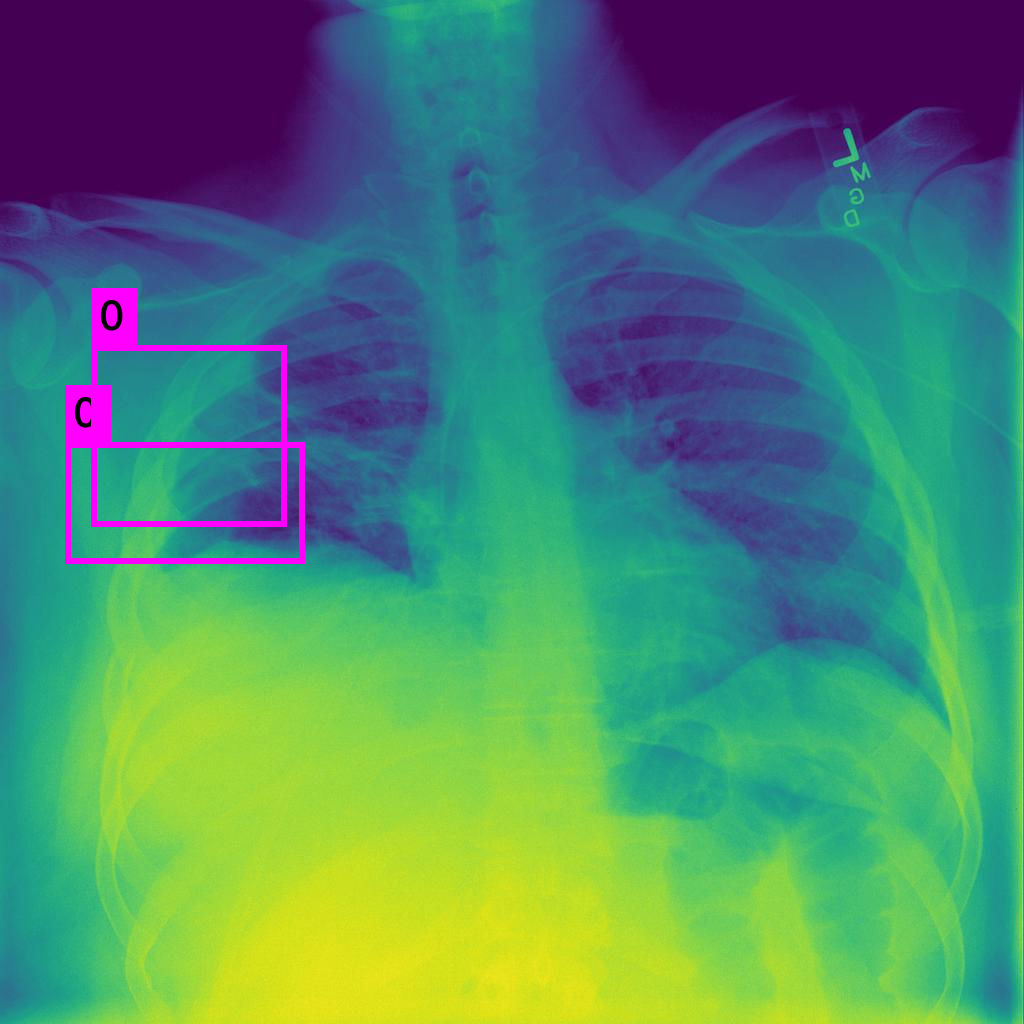

In [0]:
#from google.colab.patches import cv2_imshow
#cv2_imshow('build/predictions.jpg')
from IPython.display import Image
Image(filename='predictions.jpg')